# Dimensionality Reduction for Training Set

It isn't feasible to use all ~20,000 genes during training. Instead, we can use dimensionality reduction to create a new set of features and train on those.

# Inputs

In [1]:
import rnaseq_lib3 as r

import pandas as pd
import numpy as np
import pymc3 as pm
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Normal

## Current Method (Gene Subset)

In [3]:
sample = tumor.loc['TCGA-KK-A7B2-01']
classes = normal.tissue.unique()

In [4]:
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', n=50)
training_genes += ['ARAF', 'PARP1']

In [5]:
m, t = r.outlier.run_model(sample, normal, 'tissue', 
                           training_genes=training_genes,
                           beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [13:49<00:00,  2.55draws/s] 
The number of effective samples is smaller than 25% for some parameters.


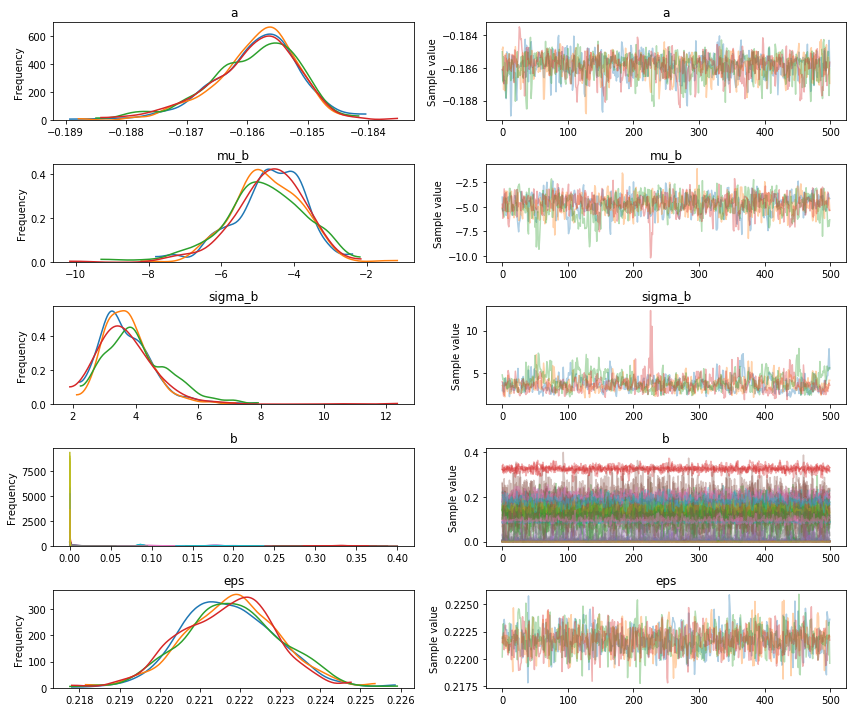

In [6]:
pm.traceplot(t);

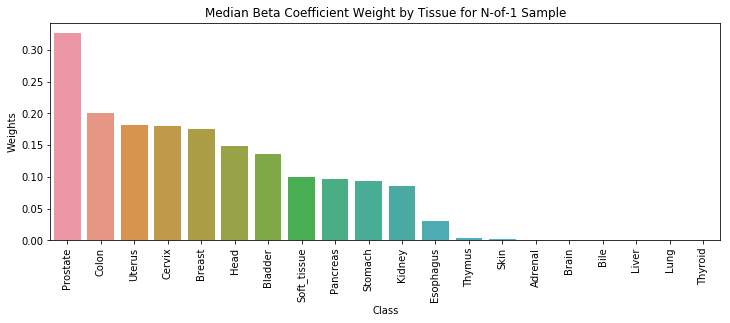

In [7]:
r.outlier.plot_weights(classes, t)

In [8]:
ppc = pm.sample_ppc(t, model=m)

100%|██████████| 500/500 [00:24<00:00, 20.42it/s]


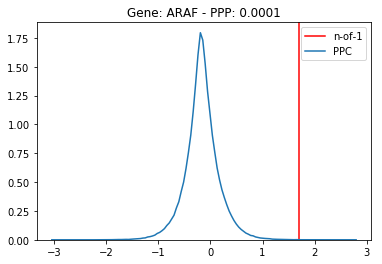

In [9]:
gene = 'ARAF'
z_true = sample[gene]
z = ppc[gene].ravel()

plt.axvline(z_true, label='n-of-1', c='r')
sns.kdeplot(z, label='PPC')
ppp = round(sum(z_true < z) / len(z), 4)
plt.title(f'Gene: {gene} - PPP: {ppp}');

## PCA (Class Unaware)

In [43]:
from sklearn.decomposition import PCA

In [44]:
n = 50
X_genes = [f'Gene{x}' for x in range(n)]
pca = PCA(n_components=n)

Add sample to combined df

In [45]:
combined_df = normal.append(sample)

Perform PCA then extract sample

In [46]:
X = pca.fit_transform(combined_df[genes])

In [47]:
y = pd.Series(X[-1, :], index=X_genes)

In [48]:
X = X[:-1, :]
X = pd.DataFrame(X, index=normal.index)
X.columns = X_genes

Add back in metadata

In [49]:
for col in df.columns[:5]:
    X[col] = df[col]
    y[col] = sample[col]

In [50]:
m_pca, t_pca = r.outlier.run_model(y, X, 'tissue', 
                                   training_genes=X_genes,
                                   beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [10:18<00:00,  4.47draws/s] 
The number of effective samples is smaller than 25% for some parameters.


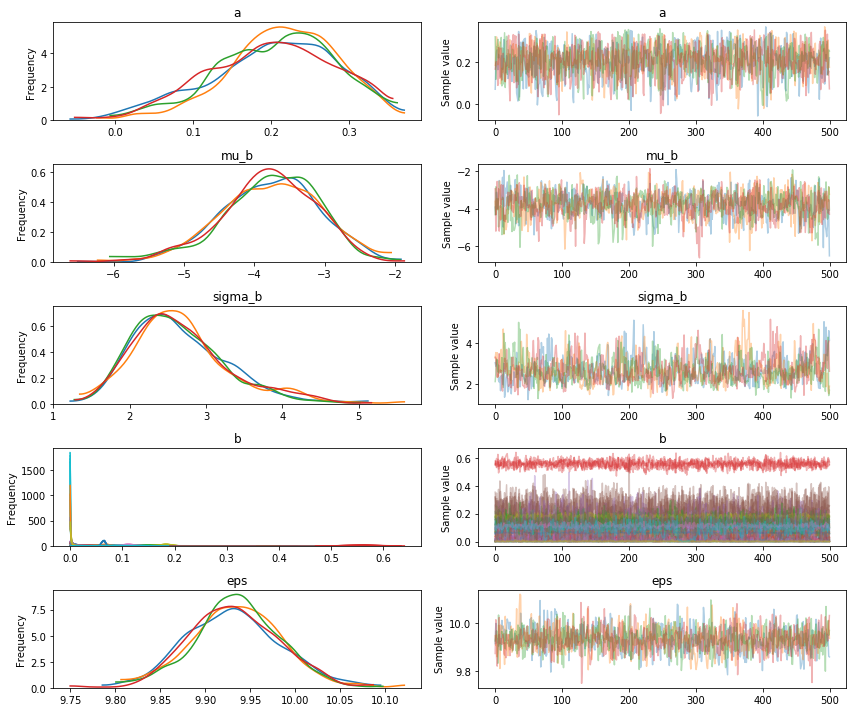

In [51]:
pm.traceplot(t_pca);

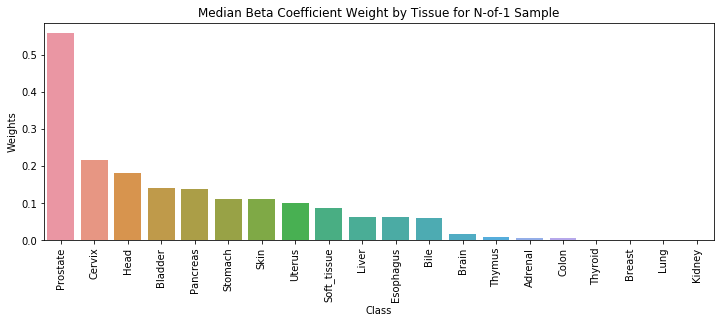

In [52]:
r.outlier.plot_weights(classes, t_pca)

In [53]:
ppc_pca = pm.sample_ppc(t_pca, model=m_pca)

100%|██████████| 500/500 [00:43<00:00, 11.51it/s] 


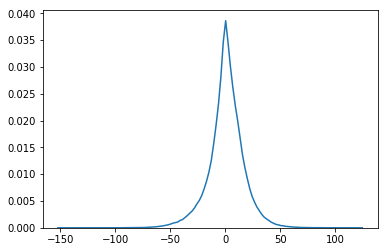

In [56]:
sns.kdeplot(ppc_pca['Gene0'].ravel())

## Linear Discriminant Analysis (Class Aware)

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [97]:
y = normal.tissue.tolist() + ['cancer']

In [101]:
lda = LinearDiscriminantAnalysis(n_components=50)
X_lda = lda.fit(combined_df[genes], y).transform(combined_df[genes])

In [111]:
X_genes = [f'Gene{x}' for x in range(20)]

In [112]:
y = pd.Series(X_lda[-1, :], index=X_genes)

In [113]:
X = X_lda[:-1, :]
X = pd.DataFrame(X, index=normal.index)
X.columns = X_genes

In [114]:
for col in df.columns[:5]:
    X[col] = df[col]
    y[col] = sample[col]

In [115]:
m_lda, t_lda = r.outlier.run_model(y, X, 'tissue', 
                                   training_genes=X_genes,
                                   beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:55<00:00,  3.78draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


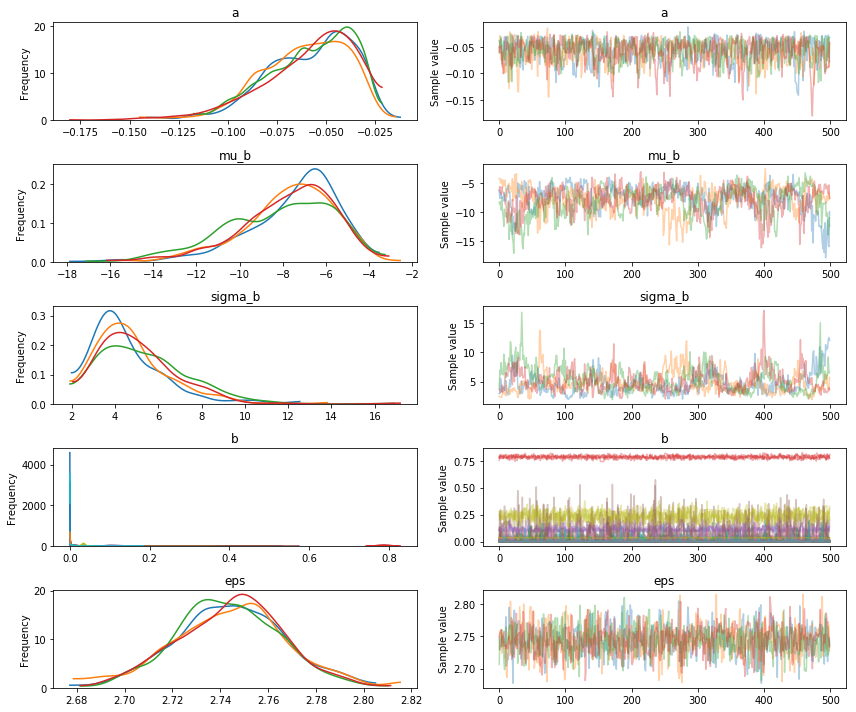

In [116]:
pm.traceplot(t_lda);

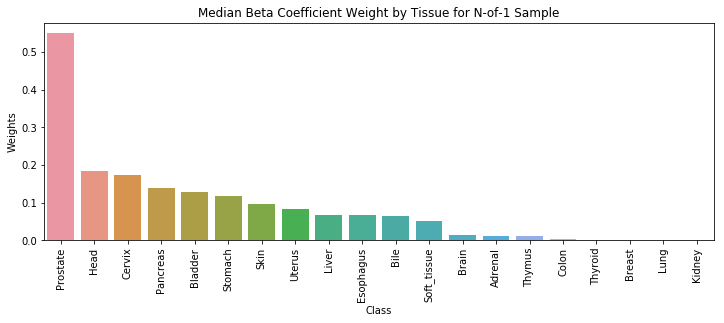

In [117]:
r.outlier.plot_weights(classes, t_pca)

## PCA, Add in drug_genes

In [20]:
n = 50
X_genes = [f'Gene{x}' for x in range(n)] + ['ARAF', 'PARP1']
pca = PCA(n_components=n)

Add sample to combined df

In [21]:
combined_df = normal.append(sample)

Perform PCA on dataframe (minus drug genes)

In [22]:
X = pca.fit_transform(combined_df[genes].drop(['ARAF', 'PARP1'], axis=1))

Add in back drug genes

In [23]:
X = np.append(X, np.array(combined_df[['ARAF', 'PARP1']]), axis=1)

In [24]:
y = pd.Series(X[-1, :], index=X_genes)

In [25]:
X = X[:-1, :]
X = pd.DataFrame(X, index=normal.index)
X.columns = X_genes

Add back in metadata

In [26]:
for col in df.columns[:5]:
    X[col] = df[col]
    y[col] = sample[col]

In [27]:
m_pca_dg, t_pca_dg = r.outlier.run_model(y, X, 'tissue', 
                                   training_genes=X_genes,
                                   beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [13:12<00:00,  3.05draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


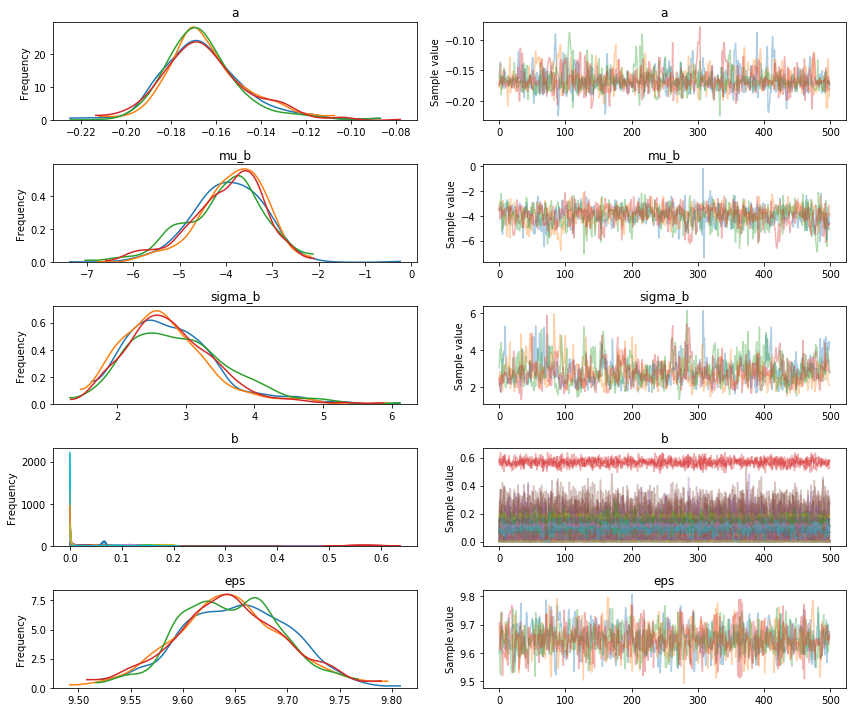

In [28]:
pm.traceplot(t_pca_dg);

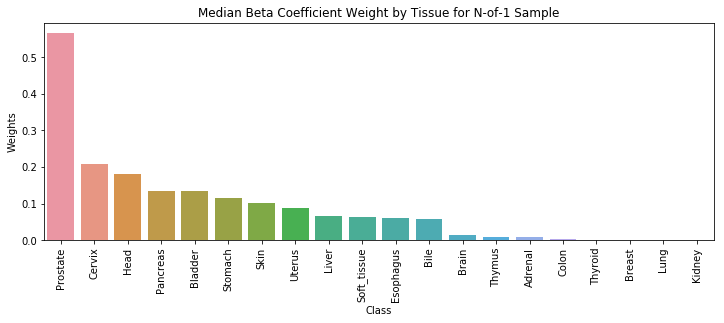

In [29]:
r.outlier.plot_weights(classes, t_pca_dg)

In [30]:
ppc = pm.sample_ppc(t_pca_dg, model=m_pca_dg)

100%|██████████| 500/500 [00:35<00:00, 13.90it/s]


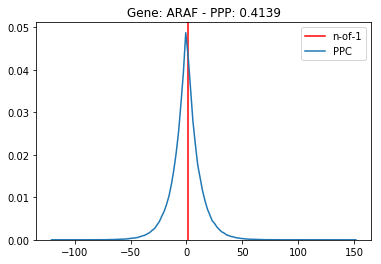

In [31]:
gene = 'ARAF'
z_true = sample[gene]
z = ppc[gene].ravel()

plt.axvline(z_true, label='n-of-1', c='r')
sns.kdeplot(z, label='PPC')
ppp = round(sum(z_true < z) / len(z), 4)
plt.title(f'Gene: {gene} - PPP: {ppp}');

# GTEx

## Current Method (Gene Subset)

In [ ]:
sample = tumor.loc['TCGA-KK-A7B2-01']
classes = normal.tissue.unique()

In [4]:
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', n=50)
training_genes += ['ARAF', 'PARP1']

In [ ]:
m, t = r.outlier.run_model(sample, normal, 'tissue', 
                           training_genes=training_genes,
                           beta_func=pm.LogitNormal)

In [ ]:
pm.traceplot(t);

In [ ]:
r.outlier.plot_weights(classes, t)

# TEST - Inferring PPC From Linear 

In [128]:
import scipy.stats as st

In [120]:
ppc = pm.sample_ppc(t, model=m)

100%|██████████| 500/500 [00:25<00:00, 19.60it/s]


In [143]:
zs = np.zeros([500, len(normal)])

Try to make a (2000 x len_normal_samples) array to emulate PPC

In [150]:
a + normal[normal['tissue'] == c][gene] * t['b'][i, j]

TCGA-SQ-A6I4-11   -0.185366
TCGA-P8-A5KD-11   -0.185692
TCGA-P8-A5KC-11   -0.185667
Name: ARAF, dtype: float32

In [153]:
t['b'][0, :]

array([2.15795045e-03, 2.02351448e-04, 1.82501464e-01, 4.38489815e-05,
       1.67078870e-01, 2.15011515e-01, 2.04240249e-01, 2.71333272e-02,
       1.52170068e-01, 8.70267394e-02, 8.66689673e-05, 1.07708544e-04,
       1.07556385e-01, 3.33013867e-01, 2.35585588e-03, 1.68221742e-01,
       9.57501189e-02, 3.15497551e-03, 4.93362374e-05, 1.82601095e-01])

In [195]:
z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

In [212]:
i = 0

In [217]:
laplace = st.laplace.rvs(loc=z[i], scale=t['eps'][i], size=100)

In [237]:
t[

-0.45664770802837873

In [258]:
t['b'].shape

(2000, 20)

In [68]:
gene = 'PARP1'
z = t['a'].mean()
#z = t['a']
for i, g in enumerate(classes):
    #samples = normal[normal['tissue'] == g][gene].mean()
    samples = np.random.choice(normal[normal['tissue'] == g][gene])#, len(z))
    #samples = np.array(normal[normal['tissue'] == g][gene])
    z += t['b'][:, i].mean() * samples

In [73]:
z = np.random.laplace(loc=z, scale=t['eps'].mean(), size=500000)

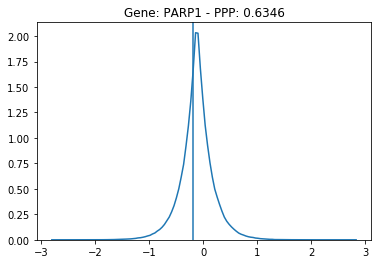

In [74]:
#samples = []
#for i in range(len(z)):
#    laplace = st.laplace.rvs(loc=z[i], scale=t['eps'][i], size=500)
#    samples.extend(list(laplace))
#z = samples
#z = st.laplace.rvs(loc=z, scale=t['eps']) 
#z = np.random.choice(z, 363000)

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

Text(0.5, 1.0, 'Gene: PARP1 - PPP: 0.4769')

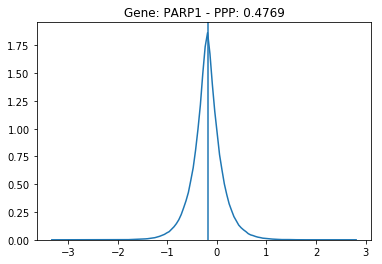

In [221]:
gene = 'PARP1'
z = ppc[gene].ravel()
z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)
sns.kdeplot(z)
plt.axvline(z_true)
plt.title(f'Gene: {gene} - PPP: {ppp}')

In [175]:
t['b'][0, ]

array([2.15795045e-03, 2.02351448e-04, 1.82501464e-01, 4.38489815e-05,
       1.67078870e-01, 2.15011515e-01, 2.04240249e-01, 2.71333272e-02,
       1.52170068e-01, 8.70267394e-02, 8.66689673e-05, 1.07708544e-04,
       1.07556385e-01, 3.33013867e-01, 2.35585588e-03, 1.68221742e-01,
       9.57501189e-02, 3.15497551e-03, 4.93362374e-05, 1.82601095e-01])

In [137]:
for i in t['a']:
    print(i);break

-0.18528816248440852


In [130]:
t['b'][:, 0].shape

(2000,)

In [123]:
ppc['SFTPC'].shape

(500, 726)

In [127]:
t['a'].shape

(2000,)

# TEST - inferring ppc from linear

Text(0.5, 1.0, 'Gene: PARP1 - PPP: 0.4776')

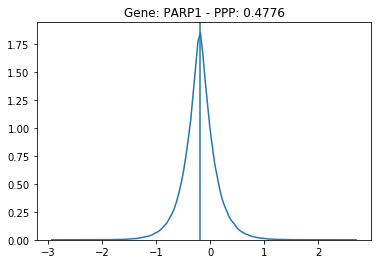

In [10]:
gene = 'PARP1'
z = ppc[gene].ravel()
z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)
sns.kdeplot(z)
plt.axvline(z_true)
plt.title(f'Gene: {gene} - PPP: {ppp}')

## Use Means of Trace Coefficients and Sample Median

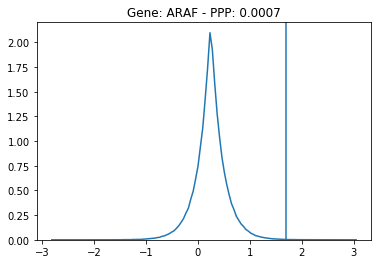

In [37]:
gene = 'ARAF'
z = np.median(t['a'])
for i, g in enumerate(classes):
    samples = normal[normal['tissue'] == g][gene].median()
    z += t['b'][:, i].mean() * samples
    
z = np.random.laplace(loc=z, scale=np.median(t['eps']), size=500000)

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Enumerate Over Trace, 1 Sample from every Background Dataset

In [40]:
trace = t

In [38]:
gene = 'ARAF'
zs = []
for i, a in tqdm(enumerate(trace['a']), total=len(t['a'])):
    z = a
    for j, g in enumerate(classes):
        samples = np.random.choice(normal[normal['tissue'] == g][gene])
        z += t['b'][i, j] * samples
    zs.append(z)

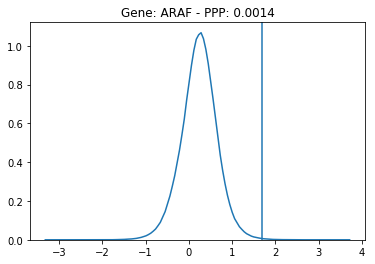

In [42]:
z = np.random.laplace(loc=zs, scale=t['eps'], size=(500, 2000)).ravel()

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Trace means, 1 sample from every background dataset

Too variable, changes everytime

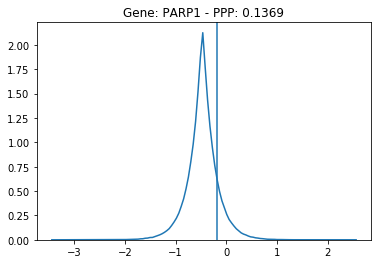

In [113]:
gene = 'PARP1'
z = t['a'].mean()
for i, g in enumerate(classes):
    samples = np.random.choice(normal[normal['tissue'] == g][gene])
    z += t['b'][:, i].mean() * samples
    
z = np.random.laplace(loc=z, scale=t['eps'].mean(), size=500000)

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Iterate N times and random sample with trace means

In [106]:
gene = 'PARP1'
zs = []
for i in tqdm(range(2000), total=2000):
    z = t['a'].mean()
    for j, g in enumerate(classes):
        samples = np.random.choice(normal[normal['tissue'] == g][gene])
        z += t['b'][:, j].mean() * samples
    zs.append(z)

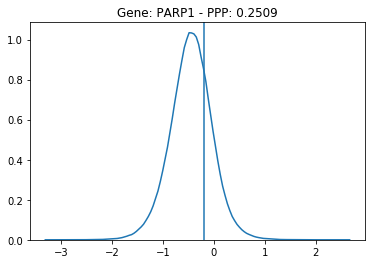

In [111]:
z = np.random.laplace(loc=zs, scale=t['eps'].mean(), size=(200, 2000)).ravel()

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Dot Product of Weight Vector and X

[sigma_b, b, eps]

In [12]:
idx = normal.tissue.astype('category').cat.codes

In [18]:
b_mean = t['b'].mean(axis=0)
b_vec = np.array([b_mean[i] for i in idx])

In [25]:
t['b'].mean(axis=0)

array([1.99379627e-03, 3.54332642e-04, 1.36446669e-01, 5.51234833e-04,
       1.75795839e-01, 1.80894160e-01, 2.02181554e-01, 3.66278654e-02,
       1.50259241e-01, 8.63841063e-02, 1.55180571e-04, 2.08929094e-04,
       9.45548148e-02, 3.26444928e-01, 9.26279450e-03, 9.84791074e-02,
       9.50777856e-02, 6.42444294e-03, 9.59096458e-05, 1.81654056e-01])

In [22]:
t['a'].mean()

-0.18589226354951285

In [26]:
b_vec.dot(normal.PARP1)

-7.240932787731286

In [21]:
z

-7.426825051280799

## Use one sample at a time

`sample_ppc` returns an (N x num_samples) matrix. Let's try to recreate this by iterating over every sample to create a 500 x 726 matrix.

In [ ]:
tissue_codes = {tissue: i for i, tissue in enumerate(normal.tissue.unique())}

In [81]:
zs = np.zeros((500, 726))
for i in tqdm(range(500), total=500):
    for j, (_, row) in enumerate(normal.iterrows()):
        z = trace['a'][i] + trace['b'][i, tissue_codes[row.tissue]] * row[gene]
        zs[i, j] = z

In [92]:
z = np.random.laplace(loc=zs.ravel(), scale=trace['eps'].mean())

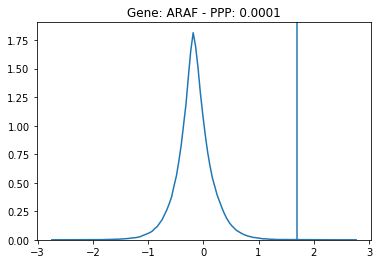

In [93]:
z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

# Speeding up PPC from Linear

In [ ]:
tissue_codes = {tissue: i for i, tissue in enumerate(normal.tissue.unique())}